IMPORTING BASIC PYTHON LIBRARIES

***MARKDOWN REPORT***

So in this linear ML model based on Logistic Regression I have tried to create 2 models for fraud detection. The dataset has been taken from kaggle(/content/PS_20174392719_1491204439457_log.csv) and works on the principle of binary classification where the fraud categories are entitled 1 and the non-fraud cases as 0.

A basic workflow of my project is:

1) importing all important modules

2) Imputation of missing values in both features and labels.

3) I have , as in all models, split the data in training and validation sets.

4) I have basically built 2 models, one which incorporates Ordinal Encoding approach as a method to deal with categorical variables and the other that incorporates One Hot Encoding.Also,I have built an alternative pipeline model to show how the code for the One Hot Encoding model can be shortened. I have later compared the performance of the two models.

5) I tried addressinng class imbalance by incorporating SMOTE, RandomUnderSampling, etc but all it gave me was a worse confusion matrix so ultimately I had to terminate that options.

6) My evaluation metrics include:classification report, matrix and accuracy score. I have also dealt with visual evaluations like AUROC plot and the AUPRC plot along with a shap dependency plot for identifying the most important features.

RESULT: turns out, for this dataset, ordinal encoding model performs slightly better


***LINK FOR DATASET:***
https://1drv.ms/x/c/4d1e2bff855456ae/EbUvyFIoRSxKsb_jb2qCIOwBpAv2DYj6AwA6lKXbLAzOCQ?e=Qnrzi0
> Add blockquote



In [ ]:
!pip install -U imbalanced-learn

**DATASET USED**
https://1drv.ms/x/c/4d1e2bff855456ae/EbUvyFIoRSxKsb_jb2qCIOwBpAv2DYj6AwA6lKXbLAzOCQ?e=llrv0E

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
data= pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')



DEFINING NECESSARY COLUMNS

In [ ]:
all_cols=data.columns
object_cols=[col for col in all_cols if data[col].dtype=='object']
num_cols=[col for col in data.columns if data[col].dtype in ['int64','float64'] and col not in ['isFraud','isFlaggedFraud']]
num_cols_data=[col for col in data.columns if data[col].dtype in ['int64','float64']]


DEFINING SCORE FUNCTION TO FIND THE SCORE OF OUR MODEL BASED ON MEAN ABSOLUTE ERROR

In [ ]:
def score_dataset(x_train,x_valid,y_train,y_valid):
  model=LogisticRegression(solver='liblinear',random_state=0,max_iter=1000)
  model.fit(x_train,y_train)
  preds=model.predict(x_valid)
  return mean_absolute_error(y_valid,preds)

SPLITTING DATA FOR TRAINING AND VALIDATION PURPOSES

In [ ]:
y=data.isFraud
x=data.drop(['isFraud','isFlaggedFraud'], axis=1)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,random_state=0)

x_train_plus=x_train.copy()
x_valid_plus=x_valid.copy()

good_label_cols=[col for col in object_cols if set(x_valid_plus[col]).issubset(set(x_train_plus[col]))]
bad_label_cols=list(set(object_cols)-set(good_label_cols))
low_cardinality_cols=[col for col in object_cols if x_train[col].nunique()<10]
high_cardinality_cols=list(set(object_cols)-set(low_cardinality_cols))
my_cols=low_cardinality_cols+num_cols
my_cols_plus=num_cols+object_cols

x_train=x_train[my_cols].copy()
x_valid=x_valid[my_cols].copy()
imputer = SimpleImputer(strategy='constant') # Or strategy='constant', fill_value=0 for example
y_train=imputer.fit_transform(np.array(y_train).reshape(-1,1))
y_valid=imputer.transform(np.array(y_valid).reshape(-1,1))
y_train=y_train.ravel()
y_valid=y_valid.ravel()

HANDLING MISSING VALUES

In [ ]:
## FOR ONE HOT ENCODING DATA
x_train_cols_num=x_train[num_cols].copy()
x_valid_cols_num=x_valid[num_cols].copy()
x_train_cols_cat=x_train[low_cardinality_cols].copy()
x_valid_cols_cat=x_valid[low_cardinality_cols].copy()

simple_imputer=SimpleImputer(strategy='constant')
imputed_x_train_cols_num=simple_imputer.fit_transform(x_train_cols_num)
imputed_x_valid_cols_num=simple_imputer.transform(x_valid_cols_num)
# Convert the NumPy arrays back to DataFrames with original column names
imputed_x_train_cols_num = pd.DataFrame(imputed_x_train_cols_num, columns=x_train_cols_num.columns, index=x_train_cols_num.index)
imputed_x_valid_cols_num = pd.DataFrame(imputed_x_valid_cols_num, columns=x_valid_cols_num.columns, index=x_valid_cols_num.index)


SIMPLE_IMPUTER=SimpleImputer(strategy='most_frequent')
imputed_x_train_cols_cat=SIMPLE_IMPUTER.fit_transform(x_train_cols_cat)
imputed_x_valid_cols_cat=SIMPLE_IMPUTER.transform(x_valid_cols_cat)
# Convert the NumPy arrays back to DataFrames with original column names
imputed_x_train_cols_cat = pd.DataFrame(imputed_x_train_cols_cat, columns=x_train_cols_cat.columns, index=x_train_cols_cat.index)
imputed_x_valid_cols_cat = pd.DataFrame(imputed_x_valid_cols_cat, columns=x_valid_cols_cat.columns, index=x_valid_cols_cat.index)

x_train=pd.concat([imputed_x_train_cols_num,imputed_x_train_cols_cat], axis=1)
x_valid=pd.concat([imputed_x_valid_cols_num,imputed_x_valid_cols_cat], axis=1)

# ## FOR ORDINAL ENCODING DATA
# simple_imputer_plus=SimpleImputer(strategy='most_frequent')
# imputed_x_train_plus=pd.DataFrame(simple_imputer_plus.fit_transform(x_train_plus))
# imputed_x_valid_plus=pd.DataFrame(simple_imputer_plus.transform(x_valid_plus))
# imputed_x_train_plus.columns=x_train_plus.columns
# imputed_x_valid_plus.columns=x_valid_plus.columns
# x_train_plus=imputed_x_train_plus
# x_valid_plus=imputed_x_valid_plus

# Replace 'missing_value' with NaN before imputation
x_train_plus = x_train_plus.replace('missing_value', np.nan)
x_valid_plus = x_valid_plus.replace('missing_value', np.nan)

## FOR ORDINAL ENCODING DATA
simple_imputer_plus=SimpleImputer(strategy='most_frequent')
imputed_x_train_plus=pd.DataFrame(simple_imputer_plus.fit_transform(x_train_plus))
imputed_x_valid_plus=pd.DataFrame(simple_imputer_plus.transform(x_valid_plus))
imputed_x_train_plus.columns=x_train_plus.columns
imputed_x_valid_plus.columns=x_valid_plus.columns
x_train_plus=imputed_x_train_plus
x_valid_plus=imputed_x_valid_plus



<ipython-input-78-26d8ac253e26>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train_plus = x_train_plus.replace('missing_value', np.nan)


In [ ]:
print(y.value_counts())

isFraud
0.0    137993
1.0       122
Name: count, dtype: int64


**APPROACH 1:** ORDINAL ENCODING FOR DEALING WITH CATEGORICAL VARIABLES

In [ ]:
label_x_train=x_train_plus.drop(bad_label_cols, axis=1).copy()
label_x_valid=x_valid_plus.drop(bad_label_cols, axis=1).copy()
ordinal_encoder=OrdinalEncoder()
label_x_train[good_label_cols]=ordinal_encoder.fit_transform(x_train_plus[good_label_cols])
label_x_valid[good_label_cols]=ordinal_encoder.transform(x_valid_plus[good_label_cols])

scaler=StandardScaler()
label_x_train[num_cols]=scaler.fit_transform(x_train[num_cols])
label_x_valid[num_cols]=scaler.transform(x_valid[num_cols])

print('MEAN ABSOLUTE ERROR FROM ORDINAL ENC0DING:')
print(score_dataset(label_x_train,label_x_valid,y_train,y_valid))

MEAN ABSOLUTE ERROR FROM ORDINAL ENC0DING:
0.0007791582080114025


**APPROACH 2:** ONE HOT ENCODING FOR DEALING WITH CATEGORICAL VARIABLES

In [ ]:

OH_encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train=pd.DataFrame(OH_encoder.fit_transform(x_train[low_cardinality_cols]))
OH_cols_valid=pd.DataFrame(OH_encoder.transform(x_valid[low_cardinality_cols]))

OH_cols_train.index=x_train.index
OH_cols_valid.index=x_valid.index

num_x_train=x_train[num_cols]
num_x_valid=x_valid[num_cols]

OH_x_train=pd.concat([num_x_train,OH_cols_train], axis=1)
OH_x_valid=pd.concat([num_x_valid,OH_cols_valid], axis=1)

OH_x_train.columns=OH_x_train.columns.astype(str)
OH_x_valid.columns=OH_x_valid.columns.astype(str)

print('MEAN ABSOLUTE ERROR FROM ONE HOT ENCODING')
print(score_dataset(OH_x_train,OH_x_valid,y_train,y_valid))

MEAN ABSOLUTE ERROR FROM ONE HOT ENCODING
0.0016455168917986385


***PIPELINE APPROACH*** (*alternative*)  (handles the case for both imputation and OH encoding)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_transformer=SimpleImputer(strategy='constant')
categorical_transformer=Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor=ColumnTransformer(transformers=[('num',numerical_transformer,num_cols),('cat',categorical_transformer,low_cardinality_cols)])

assert x_train.shape[0] == y_train.shape[0], "x_train and y_train have different number of samples!"

my_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',LogisticRegression(solver='liblinear',random_state=0,max_iter=1000))])
my_pipeline.fit(x_train,y_train)
preds=my_pipeline.predict(x_valid)

print('MEAN ABSOLUTE ERROR FROM PIPELINE')
print(mean_absolute_error(y_valid,preds))

MEAN ABSOLUTE ERROR FROM PIPELINE
0.0016455168917986385


FITTING THE MODELS WITH TRAINING DATA (EXCLUDING PIPELINE AS IT HAS ALREADY BEEN TAKEN CARE OF IN ABOVE CODE CELL)

In [ ]:
# model_ordinal=LogisticRegression(solver='liblinear',random_state=0, max_iter=1000)
# model_ordinal.fit(label_x_train, y_train)
# preds_ordinal=model_ordinal.predict(label_x_valid)

model_OH=LogisticRegression(solver='liblinear',random_state=0, max_iter=1000)
model_OH.fit(OH_x_train,y_train)
preds_OH=model_OH.predict(OH_x_valid)

model_ordinal=LogisticRegression(solver='liblinear',random_state=0, max_iter=1000)
model_ordinal.fit(label_x_train, y_train)
preds_ordinal=model_ordinal.predict(label_x_valid)

EVALUATION OF MODEL (ORDINAL ENCODING)





confusion matrix for ORDINAL ENCODING model:
 [[1591893      94]
 [   1148     893]]
accuracy of ORDINAL ENCODING model:
 0.9992208417919886
classification report of ORDINAL ENCODING model:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1591987
         1.0       0.90      0.44      0.59      2041

    accuracy                           1.00   1594028
   macro avg       0.95      0.72      0.79   1594028
weighted avg       1.00      1.00      1.00   1594028



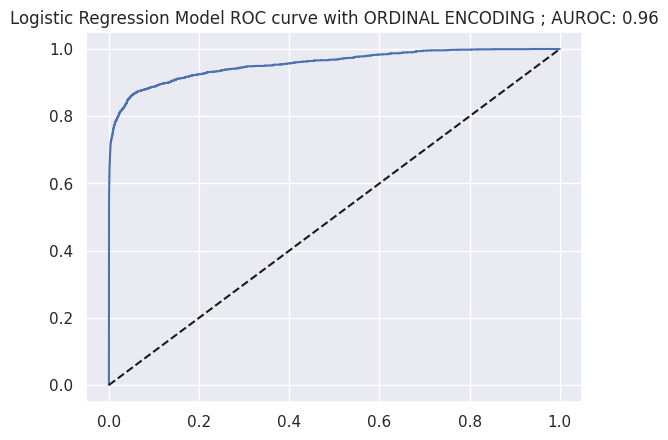

In [ ]:
print('confusion matrix for ORDINAL ENCODING model:\n',confusion_matrix(y_valid,preds_ordinal))
print('accuracy of ORDINAL ENCODING model:\n', accuracy_score(y_valid,preds_ordinal))
print('classification report of ORDINAL ENCODING model:\n' , classification_report(y_valid,preds_ordinal))

#AUROC PLOT
y_pred_proba1=model_ordinal.predict_proba(label_x_valid)[::,1]
fpr,tpr,thresholds=roc_curve(y_valid,y_pred_proba1)
auc=roc_auc_score(y_valid,y_pred_proba1)
sns.set()
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='--',color='k')
plt.xlabel='False Positive Rate'
plt.ylabel='True Positive Rate'
AUROC=np.round(roc_auc_score(y_valid,y_pred_proba1),2)
plt.title(f'Logistic Regression Model ROC curve with ORDINAL ENCODING ; AUROC: {AUROC}');
plt.show()



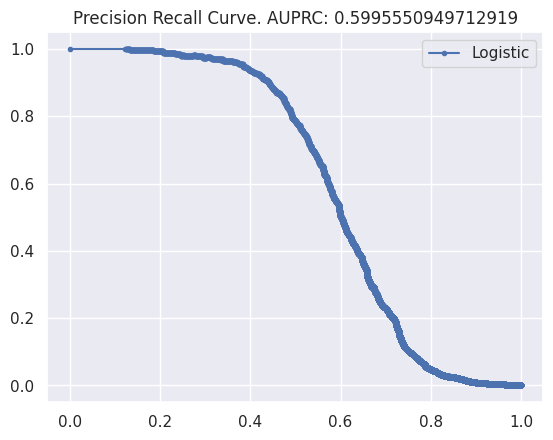

In [ ]:
average_precision = average_precision_score(y_valid, y_pred_proba1)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba1)
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel='Recall'
plt.ylabel='Precision'
plt.legend()
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()

EVALUATION OF MODEL (ONE HOT ENCODING)

In [ ]:
print('confusion matrix for OH model:\n',confusion_matrix(y_valid,preds_OH))
print('accuracy of OH model:\n', accuracy_score(y_valid,preds_OH))
print('classification report of OH model\n' , classification_report(y_valid,preds_OH))


confusion matrix for OH model:
 [[1590526    1461]
 [   1162     879]]
accuracy of OH model:
 0.9983544831082014
classification report of OH model
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1591987
         1.0       0.38      0.43      0.40      2041

    accuracy                           1.00   1594028
   macro avg       0.69      0.71      0.70   1594028
weighted avg       1.00      1.00      1.00   1594028



EVALUATION OF MODEL(PIPELINE)

confusion matrix for PIPELINE model:
 [[1590526    1461]
 [   1162     879]]
accuracy of PIPELINE model:
 0.9983544831082014
classification report of PIPELINE model:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1591987
         1.0       0.38      0.43      0.40      2041

    accuracy                           1.00   1594028
   macro avg       0.69      0.71      0.70   1594028
weighted avg       1.00      1.00      1.00   1594028



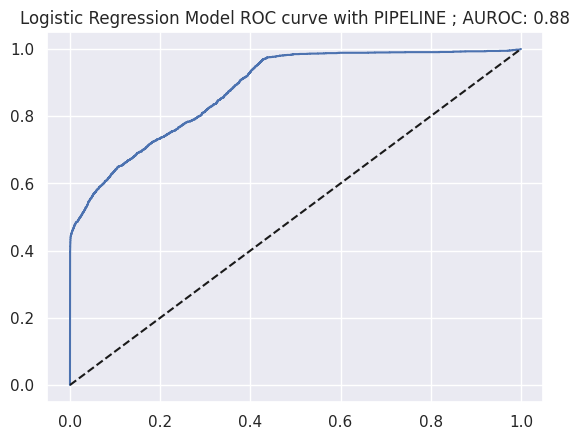

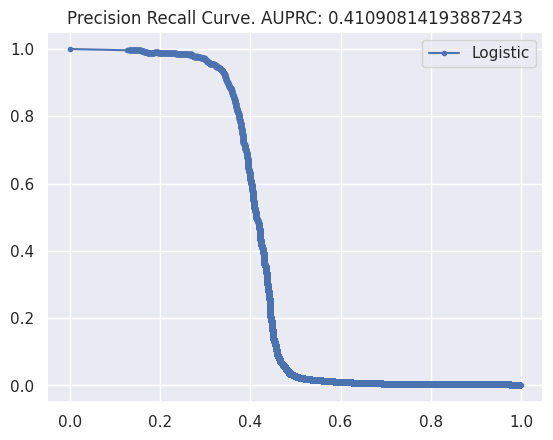

In [ ]:
print('confusion matrix for PIPELINE model:\n',confusion_matrix(y_valid,preds))
print('accuracy of PIPELINE model:\n', accuracy_score(y_valid,preds))
print('classification report of PIPELINE model:\n' , classification_report(y_valid,preds))

#AUROC PLOT
y_pred_proba2=my_pipeline.predict_proba(x_valid)[::,1]
fpr,tpr,thresholds=roc_curve(y_valid,y_pred_proba2)
auc=roc_auc_score(y_valid,y_pred_proba2)
sns.set()
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='--',color='k')
plt.xlabel='False Positive Rate'
plt.ylabel='True Positive Rate'
AUROC=np.round(roc_auc_score(y_valid,y_pred_proba2),2)
plt.title(f'Logistic Regression Model ROC curve with PIPELINE ; AUROC: {AUROC}');
plt.show()

average_precision = average_precision_score(y_valid, y_pred_proba2)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba2)
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel='Recall'
plt.ylabel='Precision'
plt.legend()
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()


INCORPORATING SHAP

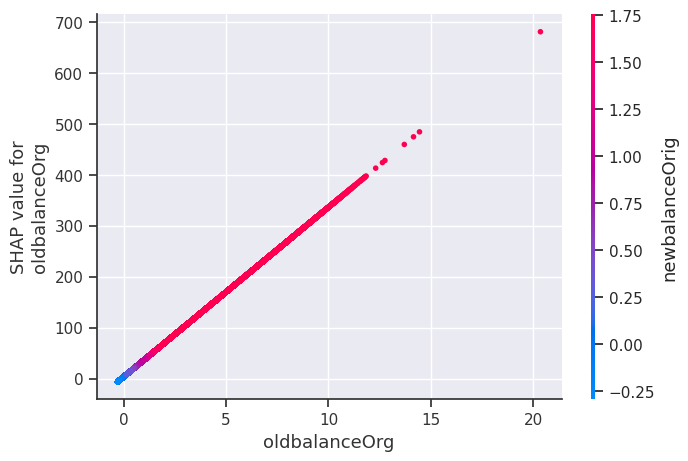

TypeError: 'str' object is not callable

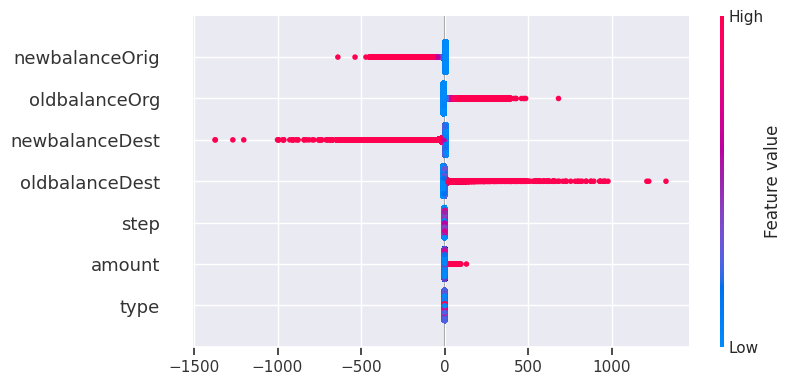

In [ ]:
import shap
# Calculate SHAP values
shap_values = shap.LinearExplainer(model_ordinal, label_x_train).shap_values(label_x_valid)
# Create summary plot

shap.dependence_plot('oldbalanceOrg', shap_values, label_x_valid)
shap.summary_plot(shap_values, label_x_valid)